In [2]:
using Arpack
using LinearAlgebra
using CairoMakie
using LaTeXStrings
using Statistics

In [3]:
# polar angle of point in range [0, 2 * pi)
function polar_angle(x, y)
    ang = 0
    if x < 0
        ang = atan(y/x) + pi
    else
        ang = atan(y/x)
    end
    if ang < 0
        ang += 2 * pi
    end
    return ang
end

polar_angle (generic function with 1 method)

In [4]:
# plaquette area for sidelength s, N-gon
function area(s, N)
    return N * s^2 / (4 * tan(pi / N))
end

area (generic function with 1 method)

<font size="12">Lattice Discretization</font>

In [5]:
function rot(pts, theta)
    new_points = Array{Float64}(undef, size(pts)[1], 2)
    for j in 1:size(pts)[1]
        x, y = pts[j, :]
        mag = norm([x, y])
        ang = polar_angle(x, y)
        new_points[j, 1] = mag * cos(ang + theta)
        new_points[j, 2] = mag * sin(ang + theta)
    end
    return new_points
end

rot (generic function with 1 method)

In [6]:
function chunk_space(x0, x1, n)
    dist = (x1 - x0)
    return collect(range(x0, x1, n + 2)[2:n + 1])
end

chunk_space (generic function with 1 method)

In [7]:
function stump_triangle(center, rad, spacing)
    x0, y0 = center
    counter = 0
    limit = Int(trunc(rad/spacing))
    x_coords = []
    y_coords = []
    counter = 0
    for j in 1:limit - 1
        if j == 1
            push!(x_coords, x0 + 0)
            push!(y_coords, y0 - spacing * 2 * sin(2 * pi / 3))
            counter += 1
        else
            x_pts = chunk_space(x0 + spacing * (j + 1) * cos(2 * pi / 3), x0 - spacing * (j + 1) * cos(2 * pi / 3), j)
            for i in 1:j
                push!(x_coords, x_pts[i])
                push!(y_coords, y0 - spacing * (j + 1) * sin(2 * pi / 3))
                counter += 1
            end
        end
    end
    points = Array{Float64}(undef, counter, 2)
    points[:, 1] = x_coords
    points[:, 2] = y_coords
    return points
end

stump_triangle (generic function with 1 method)

In [8]:
function hex_frame(center, rad, spacing)
    x_coords = []
    y_coords = []
    for j in -rad:spacing:rad
        if j != 0
            push!(x_coords, j * cos(0))
            push!(y_coords, j * sin(0))

            push!(x_coords, j * cos(2 * pi/3))
            push!(y_coords, j * sin(2 * pi / 3))

            push!(x_coords, j * cos(4 * pi/3))
            push!(y_coords, j * sin(4 * pi / 3))
        end
    end
    push!(x_coords, 0)
    push!(y_coords, 0)
    points = Array{Float64}(undef, size(x_coords)[1], 2)
    points[:, 1] = x_coords
    points[:, 2] = y_coords
    return points
end

hex_frame (generic function with 1 method)

In [9]:
function make_hex(center, rad, spacing)
    frame = hex_frame(center, rad, spacing)
    x_c = frame[:, 1]
    y_c = frame[:, 2]
    for j in 0:5
        tri = stump_triangle(center, rad, spacing)
        rot_pts = rot(tri, j * pi / 3)
        append!(x_c, rot_pts[:, 1])
        append!(y_c, rot_pts[:, 2])
    end
    points = Array{Float64}(undef, size(x_c)[1], 2)
    points[:, 1] = x_c
    points[:, 2] = y_c
    return points
end

make_hex (generic function with 1 method)

<font size="12">Single-Particle Concentrated BC</font>

In [10]:
function f(k, w)
    if k < 1 - 1/(2 * w)
        return 0
    elseif 1 - 1/(2 * w) <= k <= 1 + 1/(2 * w)
        return w * k - w + 1/2
    elseif k > 1 + 1/(2 * w)
        return 1
    end
end

f (generic function with 1 method)

In [11]:
function spinor(k, theta, n, w)
    return [1, f(k, w) * exp(im * n * theta)]
end

spinor (generic function with 1 method)

In [12]:
# Berry curvature over all plaquettes
function sp_berry_curvature(points, spacing, n, w)
    berry_list = Array{Float64}(undef, size(points)[1])
    for i in 1:size(points)[1]
        # get flux through square plaquette centered at point
        angles = Array{Float64}(undef, 6)
        momenta = Array{Float64}(undef, length(angles))
        for j in 1:length(angles)
            x_new = points[i, 1] + spacing * cos(pi/3 * (j - 1))
            y_new = points[i, 2] + spacing * sin(pi/3 * (j - 1))
            momenta[j] = norm([x_new, y_new])
            angles[j] = polar_angle(x_new, y_new)
        end

        states = Array{ComplexF64}(undef, length(angles), 2)
        for j in 1:length(angles)
            states[j, :] = normalize(spinor(momenta[j], angles[j], n, w))
        end
        P = 1
        for j in 1:length(angles)
            if j < length(angles)
                P *= dot(states[j, :], states[j + 1, :]) / abs(dot(states[j, :], states[j + 1, :]))
            else
                P *= dot(states[j, :], states[1, :]) / abs(dot(states[j, :], states[1, :]))
            end
        end
        if abs(imag(P)) < 10^(-14)
            berry_list[i] = abs(angle(P)) / area(spacing, length(angles))
        else
            berry_list[i] = angle(P) / area(spacing, length(angles))
        end
    end
    return berry_list
end

sp_berry_curvature (generic function with 1 method)

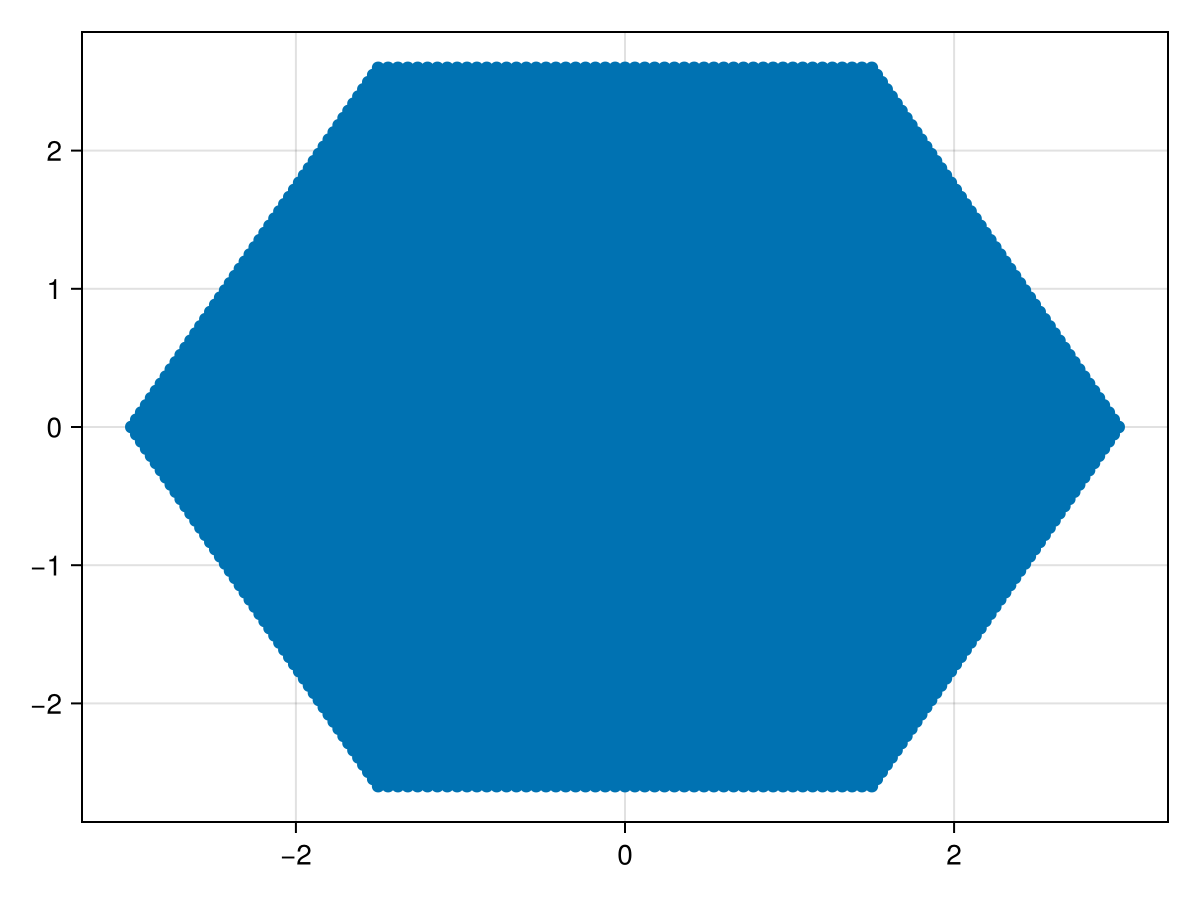

In [13]:
qlim = 3
pd = 50
spacing = 10^(-1) * (qlim / pd)
grid = make_hex([0, 0], qlim, qlim / pd)
# parameters
w = 3
n = 3
P = Figure()
ax1 = Axis(P[1, 1])
scatter!(ax1, grid[:, 1], grid[:, 2])
P

In [14]:
sp_curvature = sp_berry_curvature(grid, spacing, n, w)

7651-element Vector{Float64}:
 4.636773452892467e-15
 9.273546905784935e-15
 6.1310461476722655e-15
 4.636773452892467e-15
 9.273546905784933e-15
 1.5214412892303407e-15
 1.3910320358677394e-14
 9.273546905784932e-15
 4.654885849192828e-15
 9.273546905784935e-15
 ⋮
 1.5185433058222832e-13
 8.056393874400662e-14
 1.4431957372127805e-13
 3.408028487875963e-13
 2.498061697745817e-13
 1.150499412998943e-13
 8.085373708481239e-14
 2.9559430762189465e-14
 1.0722538609813827e-14

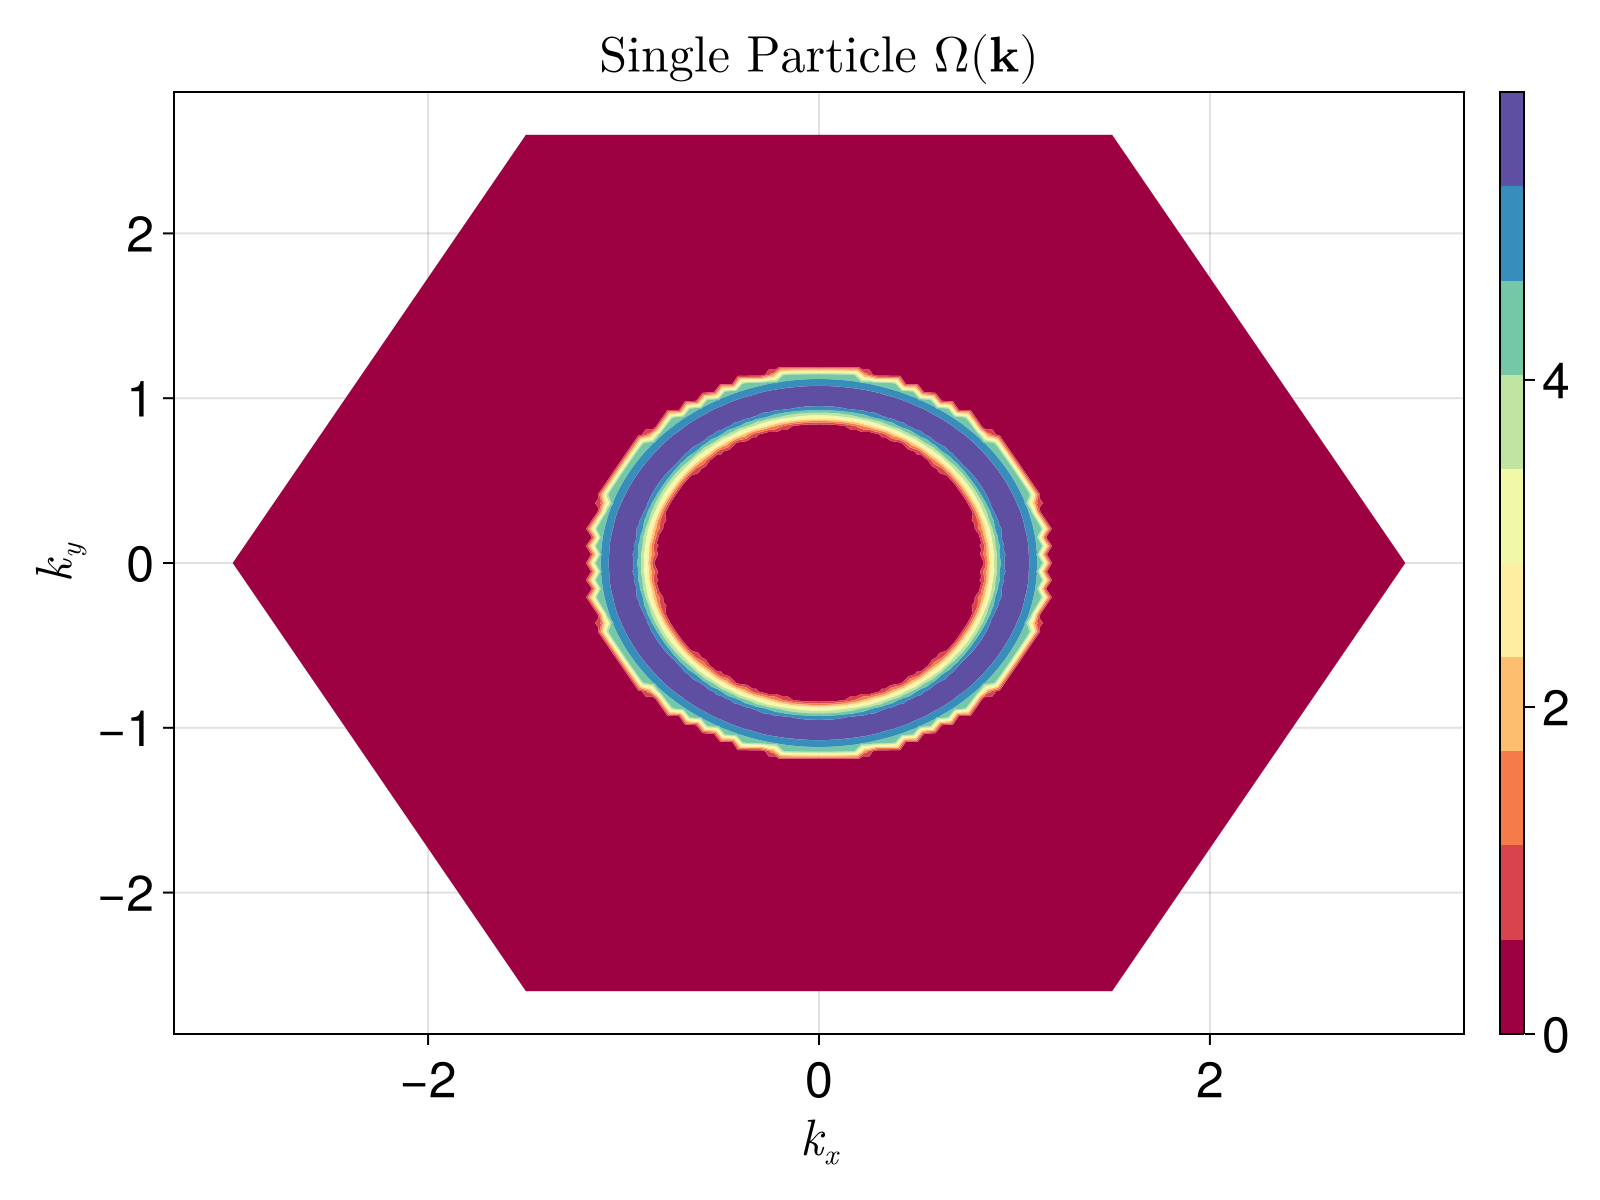

In [15]:
fig = Figure(size=(800, 600), fontsize=25)
    
ax1 = Axis(fig[1, 1], title = L"\text{Single Particle } \Omega (\textbf{k})", xlabel = L"k_x", ylabel = L"k_y")
tricontourf!(ax1, grid[:, 1], grid[:, 2], sp_curvature, colormap = :Spectral)
X, ax1, tr1 = tricontourf(grid[:, 1], grid[:, 2], sp_curvature, colormap = :Spectral)
cb1 = Colorbar(fig[1, 2], tr1)

fig

<font size="12">"Mean-field" Berry Curvature</font>

In [16]:
function H_k(q, theta, vF)
    n1 = [cos(0), sin(0)]
    n3 = [cos(2 * pi / 3), sin(2 * pi / 3)]
    n5 = [cos(4 * pi / 3), sin(4 * pi / 3)]
    k = vF * q * [cos(theta), sin(theta)]
    return [dot(k, n1) 0 0; 0 dot(k, n3) 0; 0 0 dot(k, n5)]
end

H_k (generic function with 1 method)

In [17]:
function H_mft(q, theta, delt, alph)
    # useful phase
    omega = exp(im * 2 * pi / 3)
    mat0 = [0 delt conj(delt); 
            conj(delt) 0 delt; 
            delt conj(delt) 0]
    qq = q * cos(theta) + im * q * sin(theta)
    mat1 = [0 alph * (omega * qq + conj(omega) * conj(qq)) conj(alph) * (omega^2 * qq + conj(omega^2) * conj(qq));
             conj(alph) * (omega * qq + conj(omega) * conj(qq)) 0 alph * (qq + conj(qq));
             alph * (omega^2 * qq + conj(omega^2) * conj(qq)) conj(alph) * (qq + conj(qq)) 0]
    return mat0 + mat1
end

H_mft (generic function with 1 method)

In [18]:
# Berry curvature over all plaquettes
function mf_berry_curvature(points, spacing, n, w, vF, kappa, delt, alph, pure_pos = false)
    berry_list = Array{Float64}(undef, size(points)[1])
    for i in 1:size(points)[1]
        # get flux through plaquette centered at point
        angles = Array{Float64}(undef, 20)
        momenta = Array{Float64}(undef, length(angles))
        states = Array{ComplexF64}(undef, length(angles), 3, 2)
        x0 = points[i, 1]
        y0 = points[i, 2]
        for j in 1:length(angles)
            x_new = x0 + spacing * cos(2 * pi * (j - 1) / length(angles))
            y_new = y0 + spacing * sin(2 * pi * (j - 1) / length(angles))
            momentum = norm([x_new, y_new])
            theta = polar_angle(x_new, y_new)
            ham = H_mft(momentum, theta, delt, alph) + H_k(momentum, theta, vF)
            if pure_pos == true
                gs = [1 1 1]
            else
                gs = eigvecs(Hermitian(ham))[:, 1]
            end
            for m in 1:3
                k_pt = [kappa * cos(2*pi/3 * (m - 1)), kappa * sin(2*pi/3 * (m - 1))] + [x_new, y_new]
                mom = norm(k_pt)
                ang = polar_angle(k_pt[1], k_pt[2])
                states[j, m, :] = gs[m] * spinor(mom, ang, n, w)
            end
        end
        P = 1
        for j in 1:length(angles)
            if j < length(angles)
                temp = dot(states[j, 1, :], states[j + 1, 1, :]) + dot(states[j, 2, :], states[j + 1, 2, :]) + 
                dot(states[j, 3, :], states[j + 1, 3, :])
                P *= temp
            else
                temp = dot(states[j, 1, :], states[1, 1, :]) + dot(states[j, 2, :], states[1, 2, :]) + 
                dot(states[j, 3, :], states[1, 3, :])
                P *= temp
            end
            if temp != 0
                P /= abs(temp)
            end
        end
        if abs(imag(P)) < 10^(-14)
            berry_list[i] = abs(angle(P)) / area(spacing, length(angles))
        else
            berry_list[i] = angle(P) / area(spacing, length(angles))
        end
    end
    
    return berry_list
end

mf_berry_curvature (generic function with 2 methods)

In [19]:
# parameters
a = 4/3 * pi
kappa = 4 * pi / (3 * a)
vF = 1
w = 1 / (2 - 2 * kappa/10)
n = 101
delta = -10
alpha = 10^(-11) * exp(5*pi/3 * im)

5.0000000000000005e-12 - 8.660254037844386e-12im

In [20]:
qlim = kappa
pd = 50
spacing = 10^(-1) * (qlim / pd)
grid = make_hex([0, 0], qlim, qlim / pd)

7651×2 Matrix{Float64}:
 -1.0   -0.0
  0.5   -0.866025
  0.5    0.866025
 -0.98  -0.0
  0.49  -0.848705
  0.49   0.848705
 -0.96  -0.0
  0.48  -0.831384
  0.48   0.831384
 -0.94  -0.0
  ⋮     
 -0.59  -0.710141
 -0.58  -0.727461
 -0.57  -0.744782
 -0.56  -0.762102
 -0.55  -0.779423
 -0.54  -0.796743
 -0.53  -0.814064
 -0.52  -0.831384
 -0.51  -0.848705

In [21]:
mf_curvature = mf_berry_curvature(grid, spacing, n, w, vF, kappa, delta, alpha)

7651-element Vector{Float64}:
 1.6962855640176502
 1.6962855640174075
 1.696285564017194
 1.7215878322058018
 1.7215878322059155
 1.7215878322058369
 1.7470850291995401
 1.7470850291995812
 1.7470850291993594
 1.7727690812713572
 ⋮
 2.263314143954311
 2.2642963605704103
 2.2645317163095195
 2.2640406758766587
 2.262843248404272
 2.260959091127373
 2.258407595238569
 2.2552079560537632
 2.251379229290302

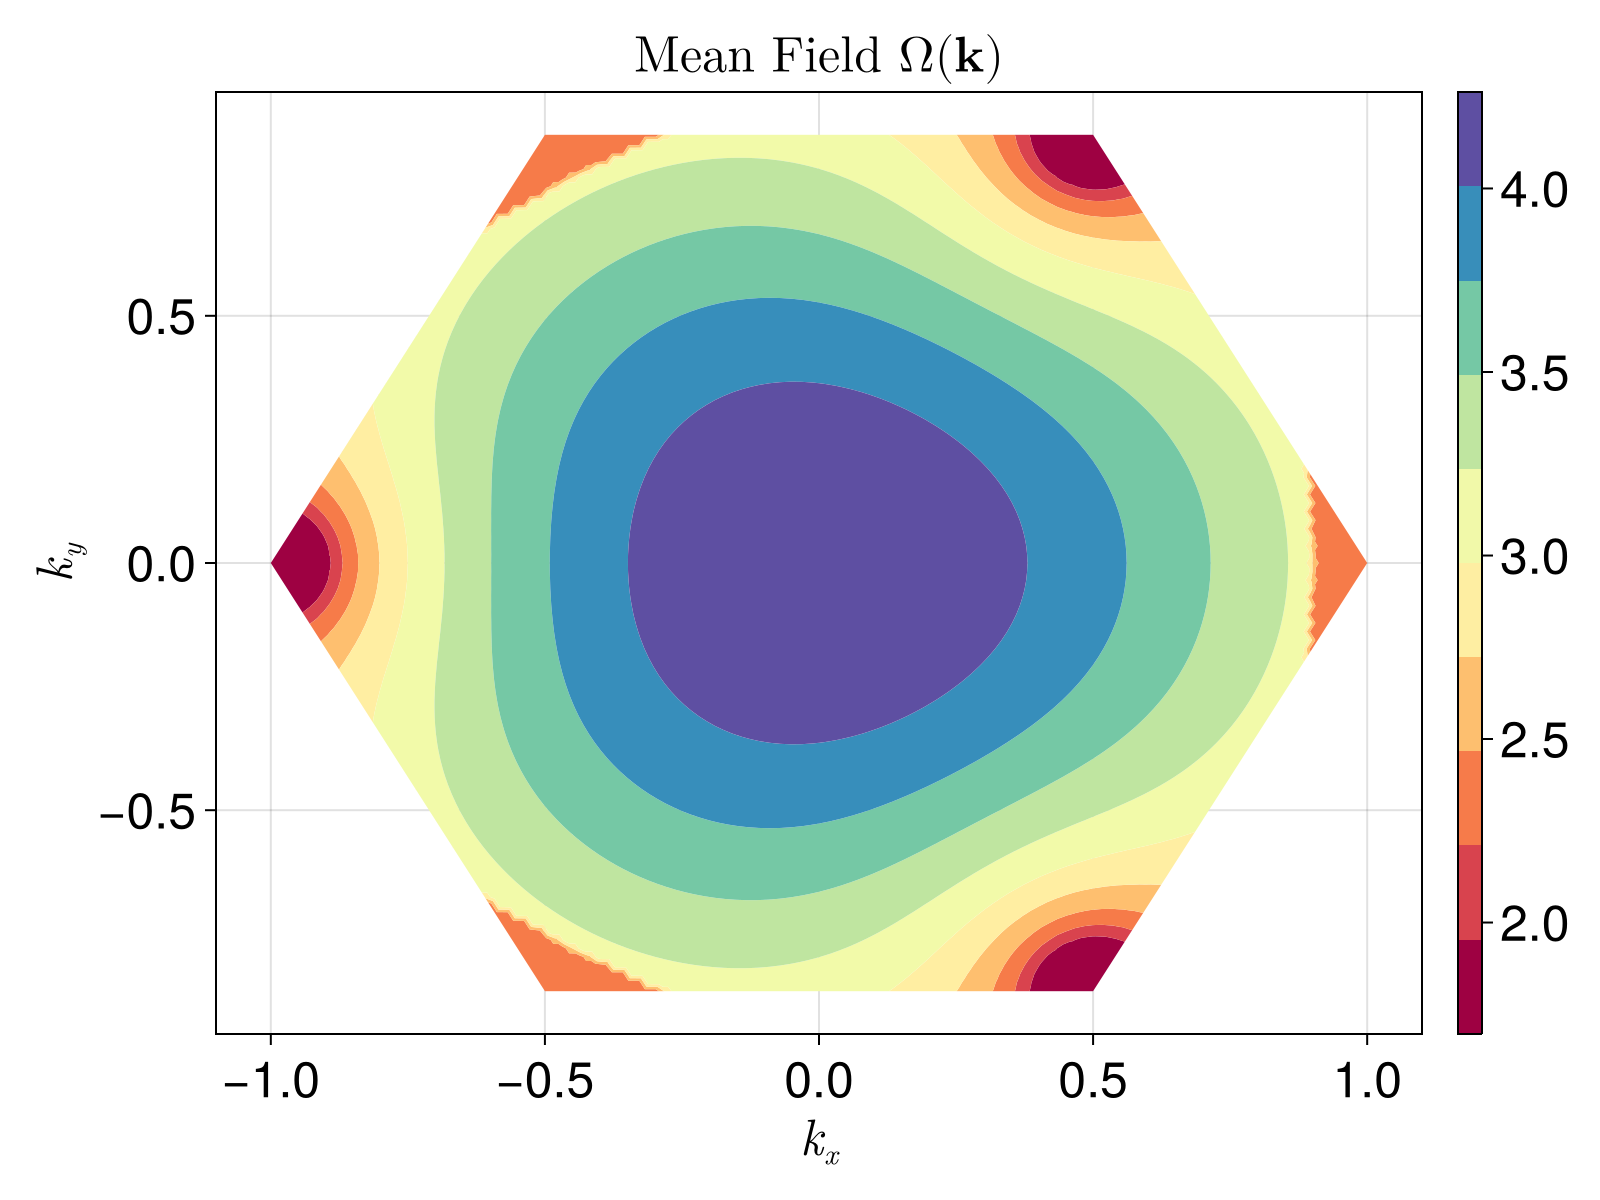

In [22]:
fig = Figure(size=(800, 600), fontsize=25)
    
ax1 = Axis(fig[1, 1], title = L"\text{Mean Field } \Omega (\textbf{k})", xlabel = L"k_x", ylabel = L"k_y")
tricontourf!(ax1, grid[:, 1], grid[:, 2], mf_curvature, colormap = :Spectral)
X, ax1, tr1 = tricontourf(grid[:, 1], grid[:, 2], mf_curvature, colormap = :Spectral)
cb1 = Colorbar(fig[1, 2], tr1)

fig

In [23]:
mom_params = Array{Float64}(undef, size(grid)[1], 2)
for j in 1:size(grid)[1]
    mom_params[j, 1] = polar_angle(grid[j, 1], grid[j, 2])
    mom_params[j, 2] = norm(grid[j, :])
end

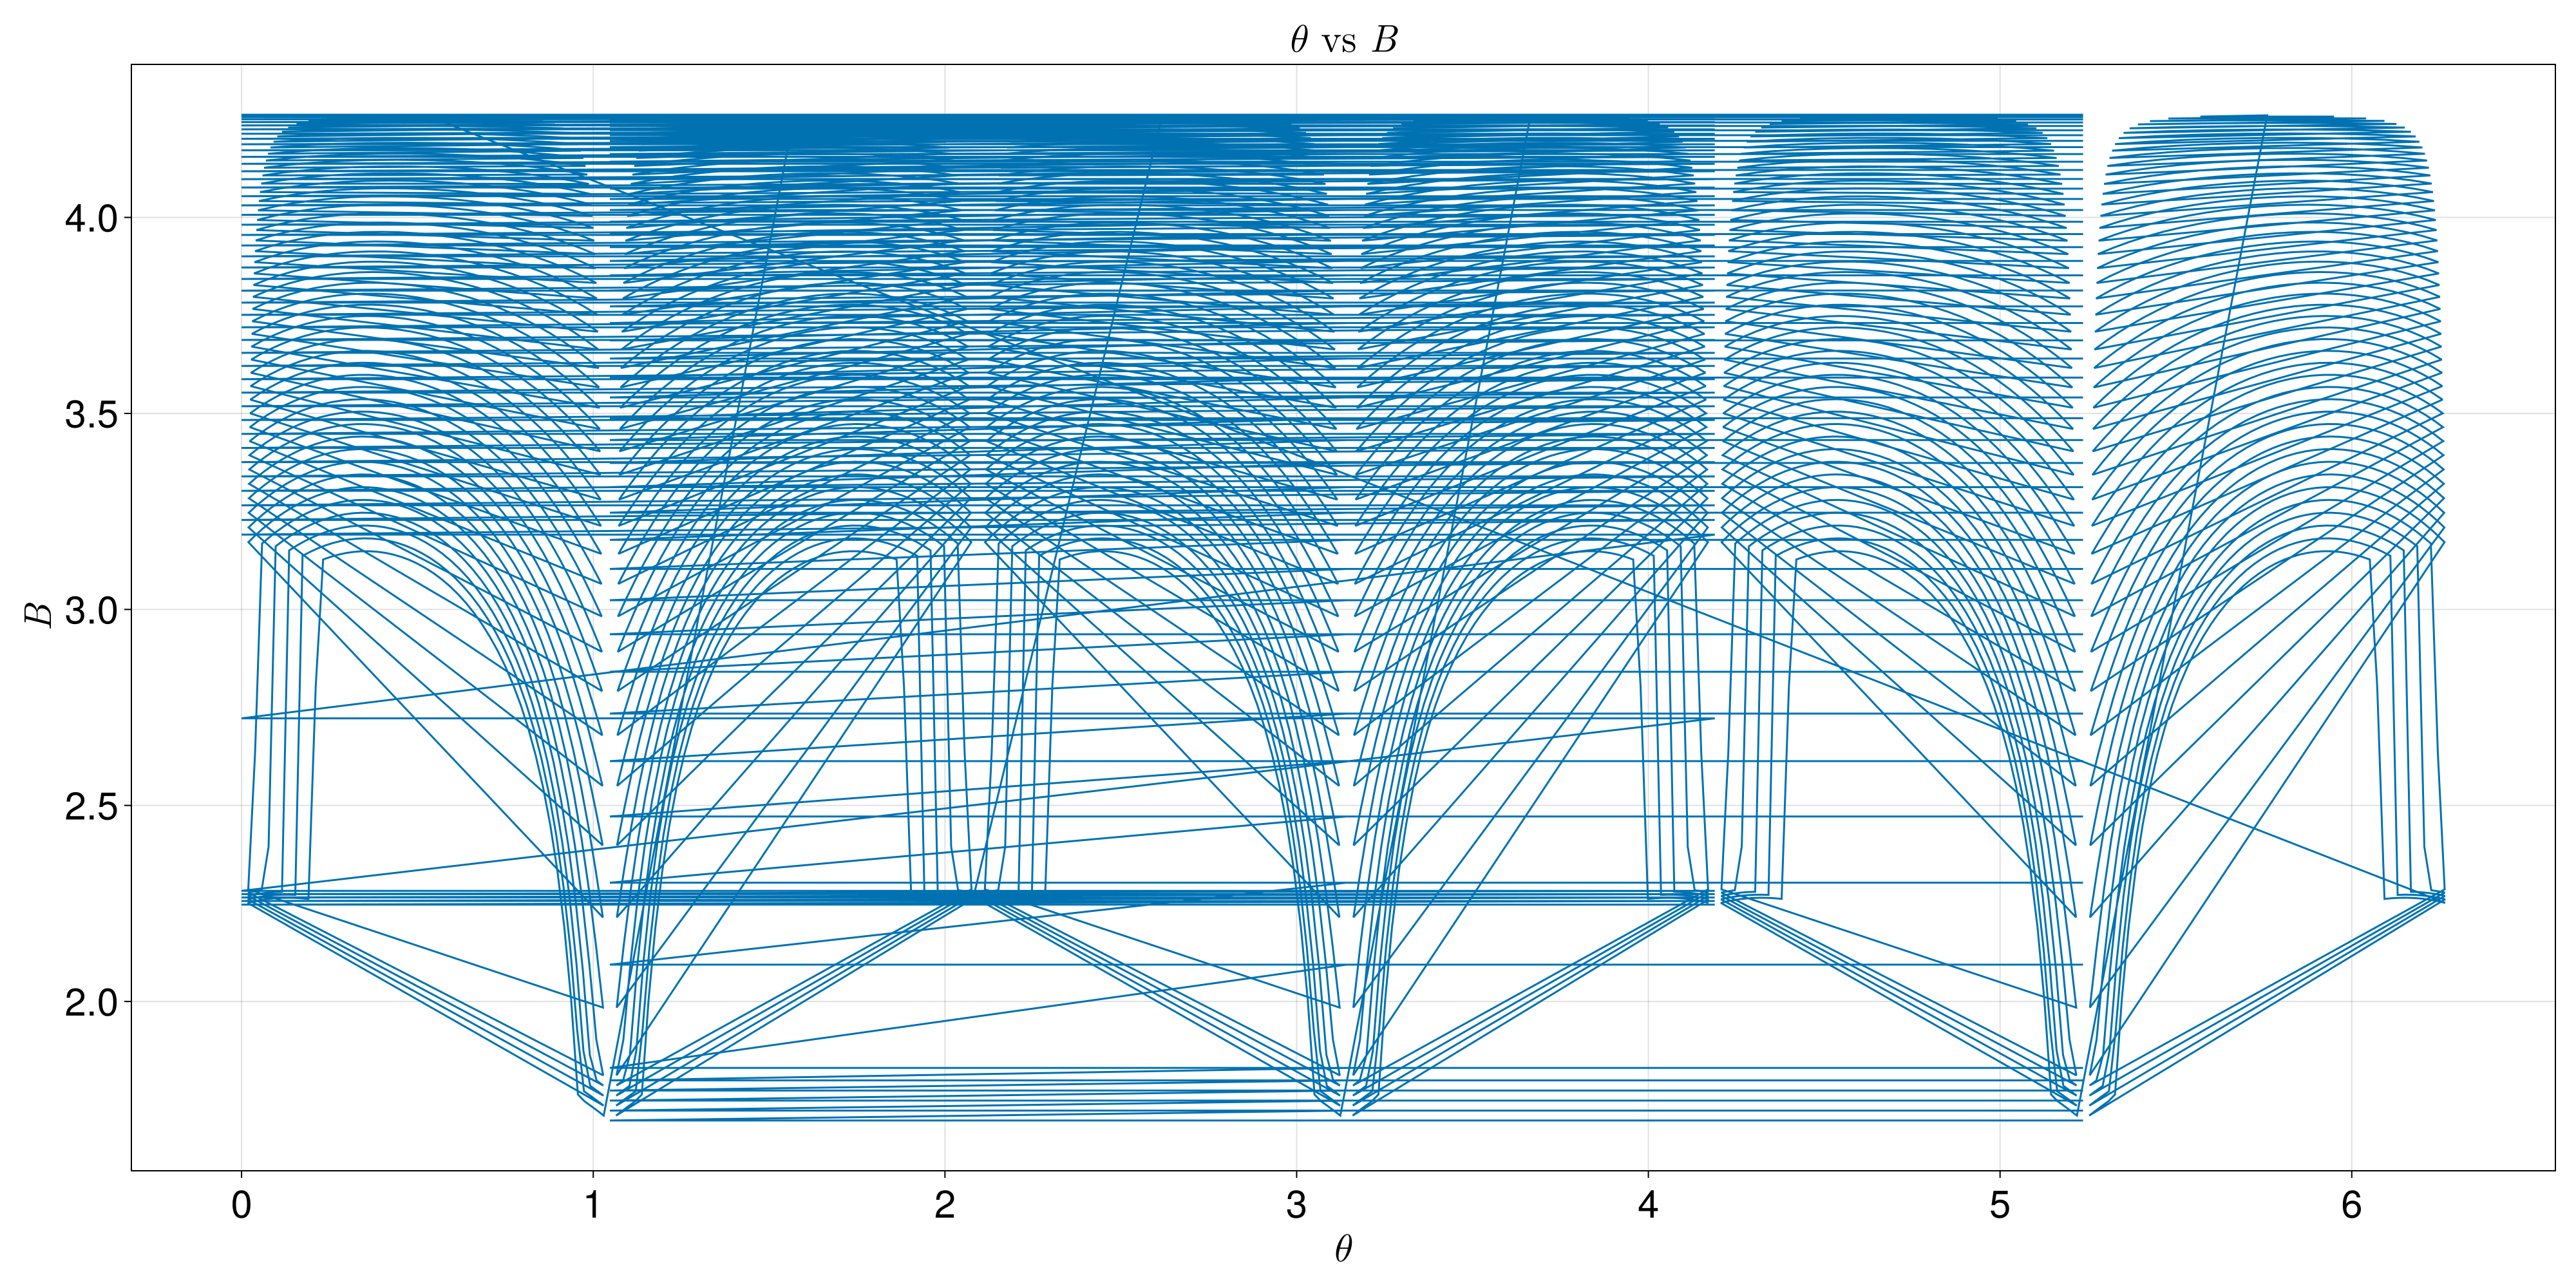

In [24]:
# create plot
P = Figure(size=(2000, 1000), fontsize=30)
# create and configure axes
ax1 = Axis(P[1, 1], title = L"\theta \text{ vs } B", xlabel = L"\theta", ylabel = L"B")
lines!(ax1, mom_params[:, 1], mf_curvature)
P

<font size="12">MF BC Comparison</font>

In [25]:
# parameters
a = 4/3 * pi
kappa = 4 * pi / (3 * a)
vF = 0
w = 1 / (2 - 2 * kappa/3)
n = 2
# note that we want to fix delta < 0 to get non-degenerate GS
delta = -1
# switching the sign of alpha increases or decreases berry curvature
alpha = 0.2

0.2

In [26]:
qlim = 0.2 * kappa
pd = 50
spacing = 10^(-1) * (qlim / pd)
grid = make_hex([0, 0], qlim, qlim / pd)

7651×2 Matrix{Float64}:
 -0.2    -0.0
  0.1    -0.173205
  0.1     0.173205
 -0.196  -0.0
  0.098  -0.169741
  0.098   0.169741
 -0.192  -0.0
  0.096  -0.166277
  0.096   0.166277
 -0.188  -0.0
  ⋮      
 -0.118  -0.142028
 -0.116  -0.145492
 -0.114  -0.148956
 -0.112  -0.15242
 -0.11   -0.155885
 -0.108  -0.159349
 -0.106  -0.162813
 -0.104  -0.166277
 -0.102  -0.169741

In [27]:
mf_curvature = mf_berry_curvature(grid, spacing, n, w, vF, kappa, delta, alpha)
no_mf_curvature = mf_berry_curvature(grid, spacing, n, w, vF, kappa, 0, 0)
folded_sp_curvature = mf_berry_curvature(grid, spacing, n, w, vF, kappa, 0, 0, true)

7651-element Vector{Float64}:
 0.11298316517924976
 0.11298316517835111
 0.1129831651793946
 0.1131661044428741
 0.11316610444018634
 0.11316610444310905
 0.11334507638593924
 0.11334507638945587
 0.11334507638692756
 0.11352008758538275
 ⋮
 0.11432331305972142
 0.11428774091605805
 0.1142486342645639
 0.11420597773302822
 0.11415975636320479
 0.11410995561859341
 0.1140565613799092
 0.11399955993742882
 0.11393893799882604

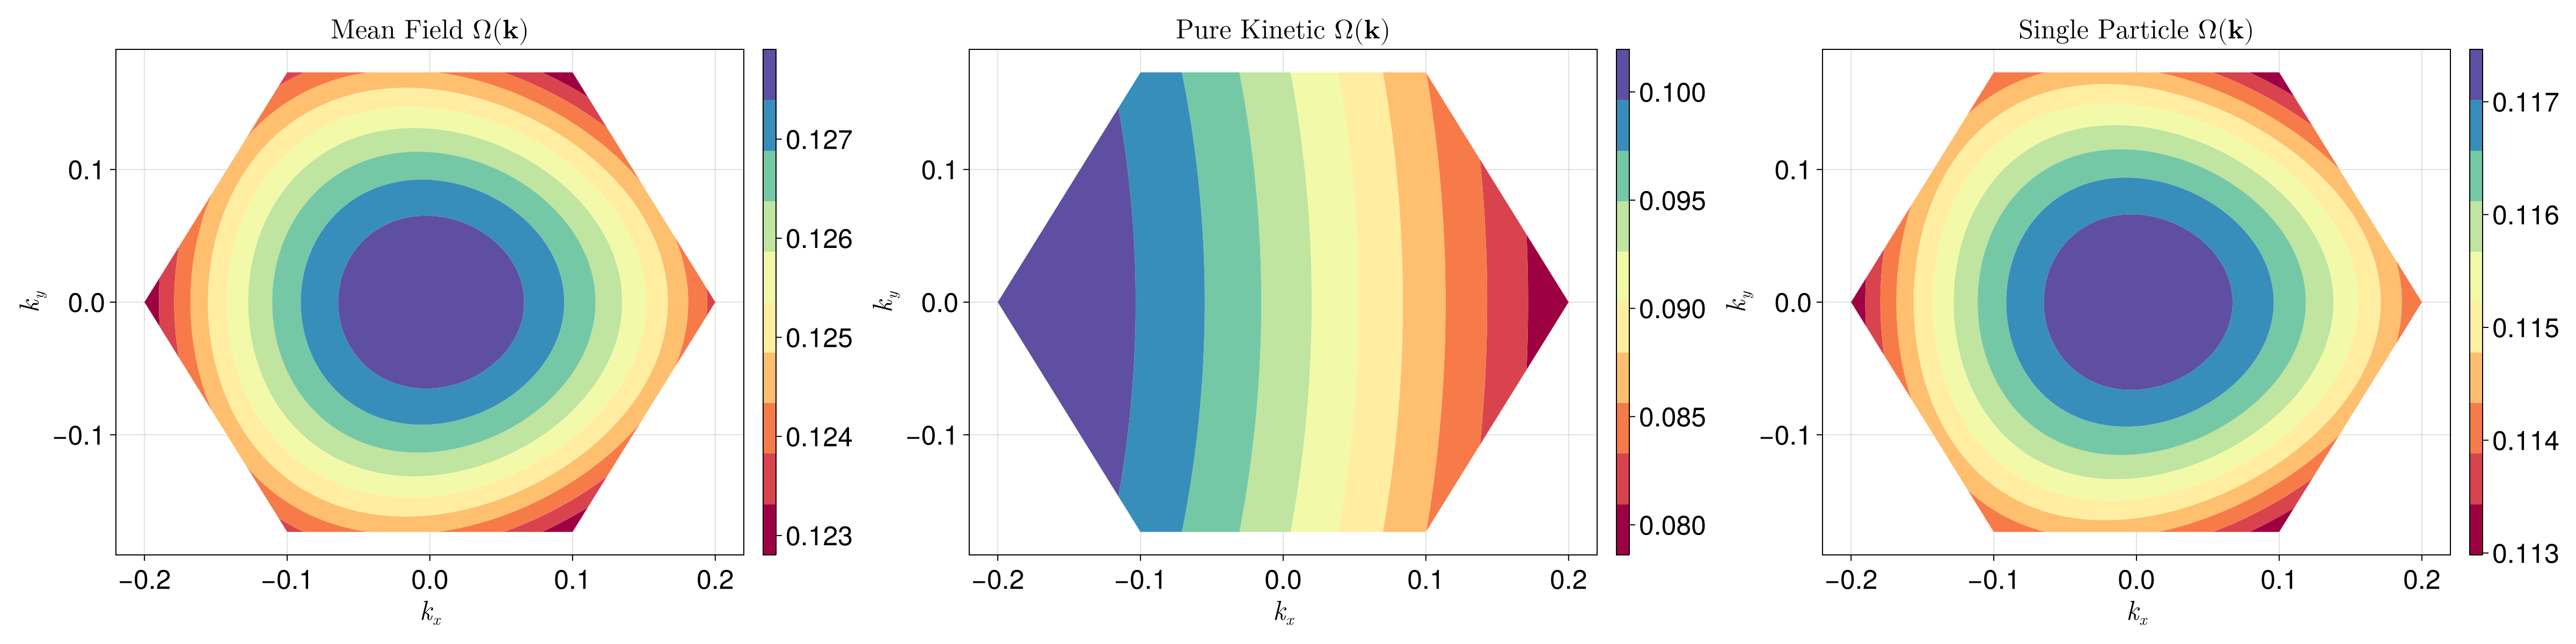

In [28]:
fig = Figure(size=(2400, 600), fontsize=25)
    
ax1 = Axis(fig[1, 1], title = L"\text{Mean Field } \Omega (\textbf{k})", xlabel = L"k_x", ylabel = L"k_y")
tricontourf!(ax1, grid[:, 1], grid[:, 2], mf_curvature, colormap = :Spectral)
X, ax1, tr1 = tricontourf(grid[:, 1], grid[:, 2], mf_curvature, colormap = :Spectral)
cb1 = Colorbar(fig[1, 2], tr1)

ax2 = Axis(fig[1, 3], title = L"\text{Pure Kinetic } \Omega (\textbf{k})", xlabel = L"k_x", ylabel = L"k_y")
tricontourf!(ax2, grid[:, 1], grid[:, 2], no_mf_curvature, colormap = :Spectral)
X, ax2, tr2 = tricontourf(grid[:, 1], grid[:, 2], no_mf_curvature, colormap = :Spectral)
cb2 = Colorbar(fig[1, 4], tr2)

ax3 = Axis(fig[1, 5], title = L"\text{Single Particle } \Omega (\textbf{k})", xlabel = L"k_x", ylabel = L"k_y")
tricontourf!(ax3, grid[:, 1], grid[:, 2], folded_sp_curvature, colormap = :Spectral)
X, ax3, tr3 = tricontourf(grid[:, 1], grid[:, 2], folded_sp_curvature, colormap = :Spectral)
cb3 = Colorbar(fig[1, 6], tr3)

fig